In [18]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
import torch
from gpytorch import kernels

from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

%matplotlib notebook
# https://towardsdatascience.com/transform-data-to-high-dimensional-kernel-space-87d62b670e0f

In [19]:
data = np.loadtxt("/home/max/Software/virgo/data/data.txt")

In [20]:
np.random.shuffle(data)
# 20k seems to be the limit for OOM
# sub_data = data[:100000]
sub_data = data

In [21]:
# norm everything
X = sub_data
print(X.shape, X.max(), X.min(), X.mean())
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
print(X.shape, X.max(), X.min(), X.mean())

# only use spatial points for kernel
if True:
    torch_subdata = torch.tensor(X[:, [0, 1, 2]])
    covar_module = kernels.LinearKernel()
    lazy_covar_matrix = covar_module(torch_subdata) 
    z_vals = lazy_covar_matrix.diag().detach().numpy()
else:
    z_vals = RBF(1.).__call__(X[:, [0, 1, 2]])[0]


X = np.array([*X.T, z_vals]).T
print(X.shape, X.max(), X.min(), X.mean())

(694764, 7) 38340.40625 -7516.96337890625 442.5116525355538
(694764, 7) 217.3859613425795 -4.197077780281189 -2.325235567795919e-16
(694764, 8) 217.3859613425795 -4.197077780281189 0.25993020971162956


In [11]:
elbos = []
for i in range(5, 15):
    model = GaussianMixture(n_components=i)
    model.fit(X)
    elbos.append(model.lower_bound_)
    print(i, model.lower_bound_)
    
plt.plot(elbos)
plt.show()    

5 -3.4846790936807612
6 -2.5408715065372127
7 -3.495102998732612
8 -3.1208153749358996
9 -1.9060265982237363
10 -1.718214813723713
11 -1.248772263689364


KeyboardInterrupt: 

ELBO -1.315315
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] [ 35257 134098  55079 115046  67827  55769  92135  47071   4501  43767
  30571  13643]


<IPython.core.display.Javascript object>


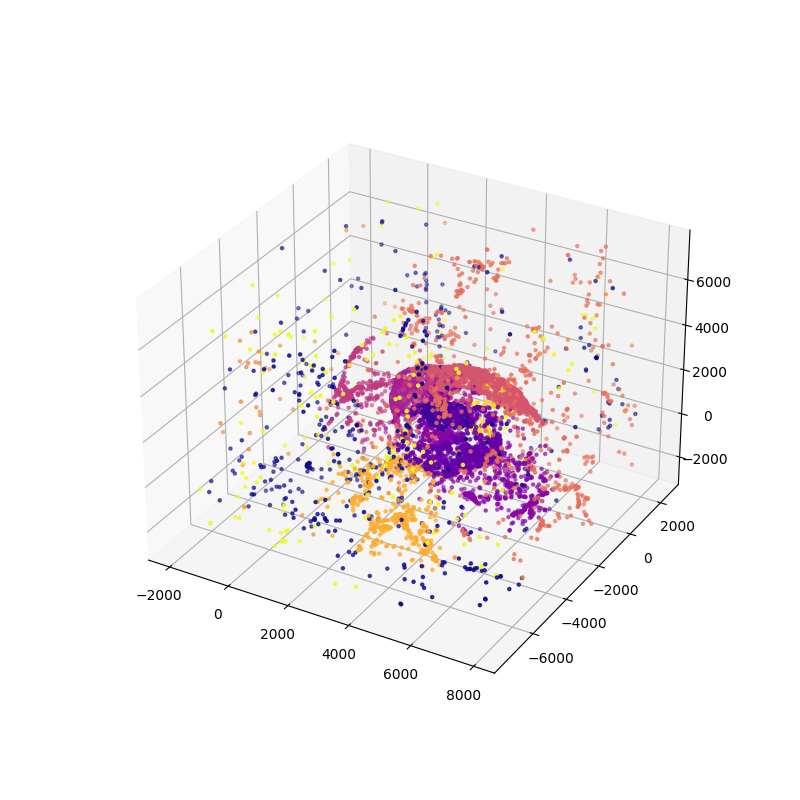

In [25]:
# model = BayesianGaussianMixture(n_components=20)
model = GaussianMixture(n_components=12)
model.fit(X)
pred_y1 = model.predict(X)
print(f"ELBO {model.lower_bound_:0.6f}")

# w_arr = np.array(model.weight_concentration_)
# print((w_arr > 1.).sum())

values, counts = np.unique(pred_y1, return_counts=True)
values = list(values)
print(values, counts)

plot_dat = np.array([sub_data.T[0], sub_data.T[1], sub_data.T[2], pred_y1]).T[:10000]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(plot_dat.T[0], plot_dat.T[1], plot_dat.T[2], c=plot_dat.T[3], marker=".", cmap="plasma")
plt.show()

1.0073141707040725 -33.558589651098224 -33.314918649106374


<IPython.core.display.Javascript object>


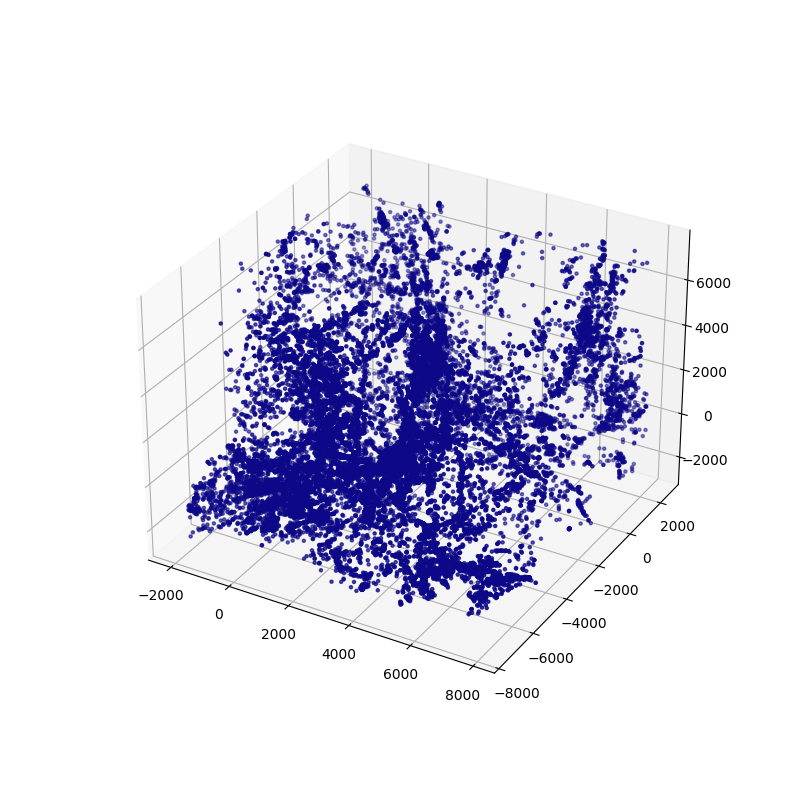

1.0543205790749688 -20.044212561080236 -19.01149703315709


<IPython.core.display.Javascript object>


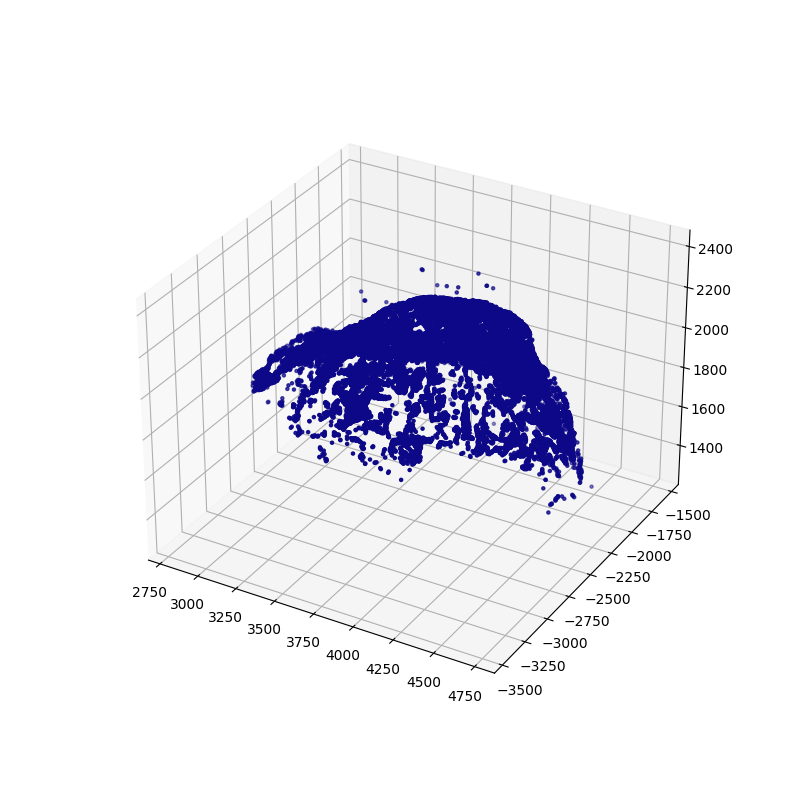

1.0657821939418348 -22.00643498301752 -20.648154105132782


<IPython.core.display.Javascript object>


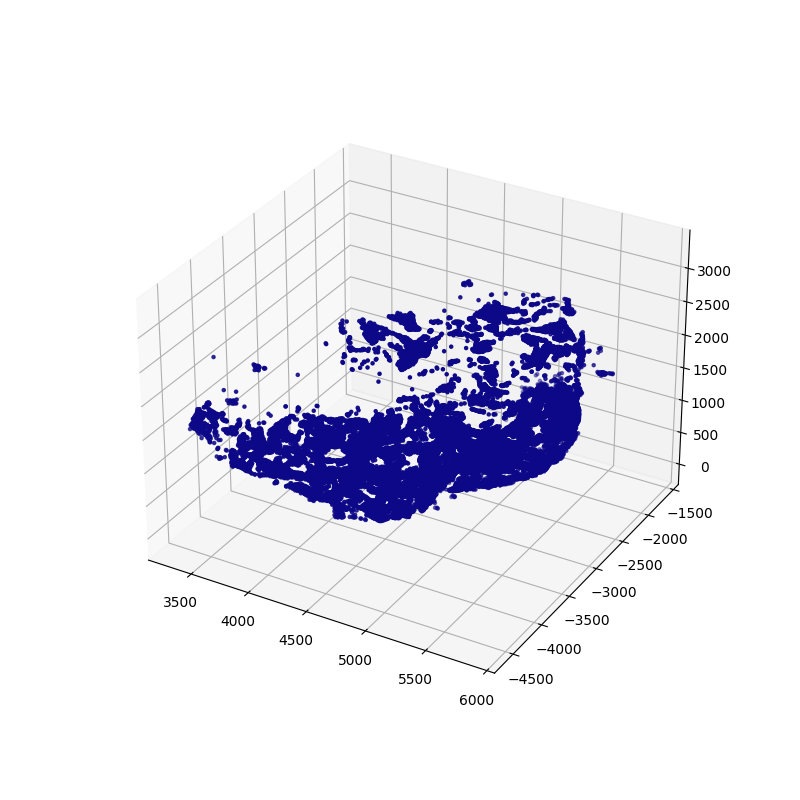

1.0266613812590313 -27.833190074517578 -27.110389640238296


<IPython.core.display.Javascript object>


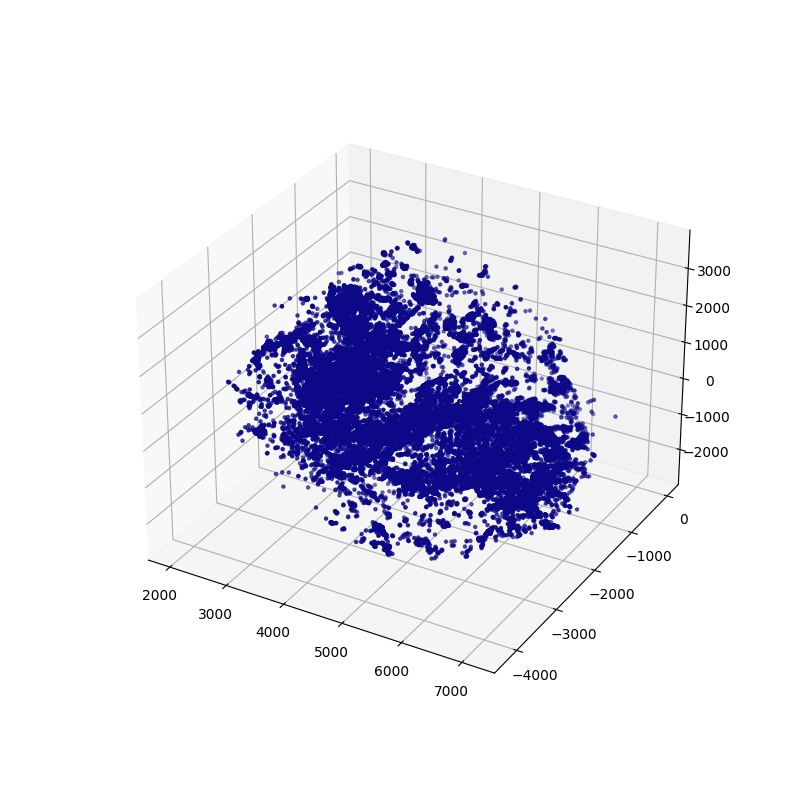

1.0686368284845067 -20.05855415574807 -18.770225413430886


<IPython.core.display.Javascript object>


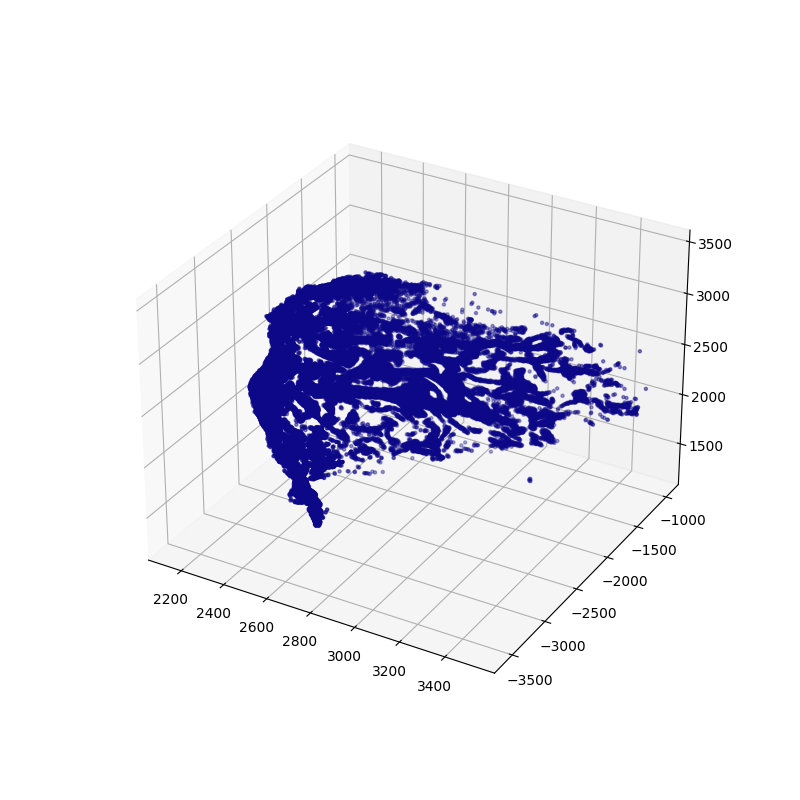

1.0297865879439199 -25.903342079292052 -25.154087635779828


<IPython.core.display.Javascript object>


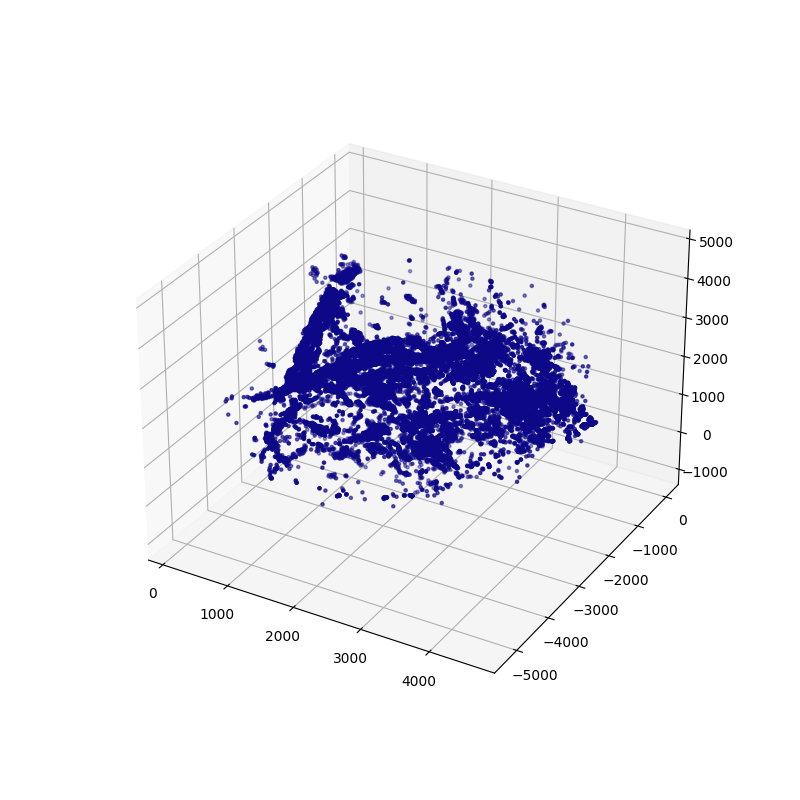

1.05664755449247 -22.749529696552266 -21.52991278863967


<IPython.core.display.Javascript object>


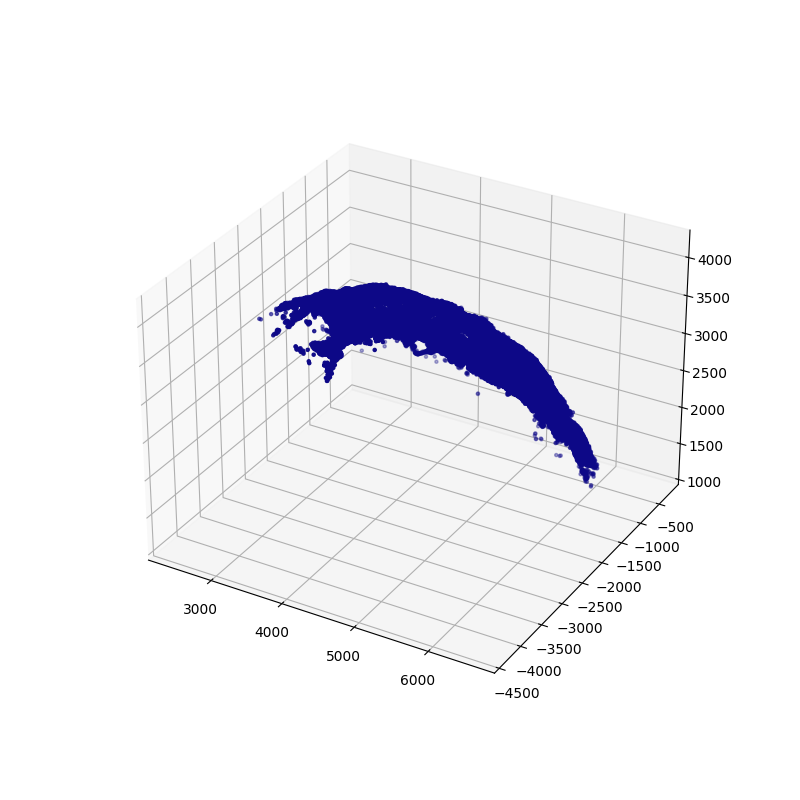

1.0101848721314206 -31.082298929744745 -30.768921399667402


<IPython.core.display.Javascript object>


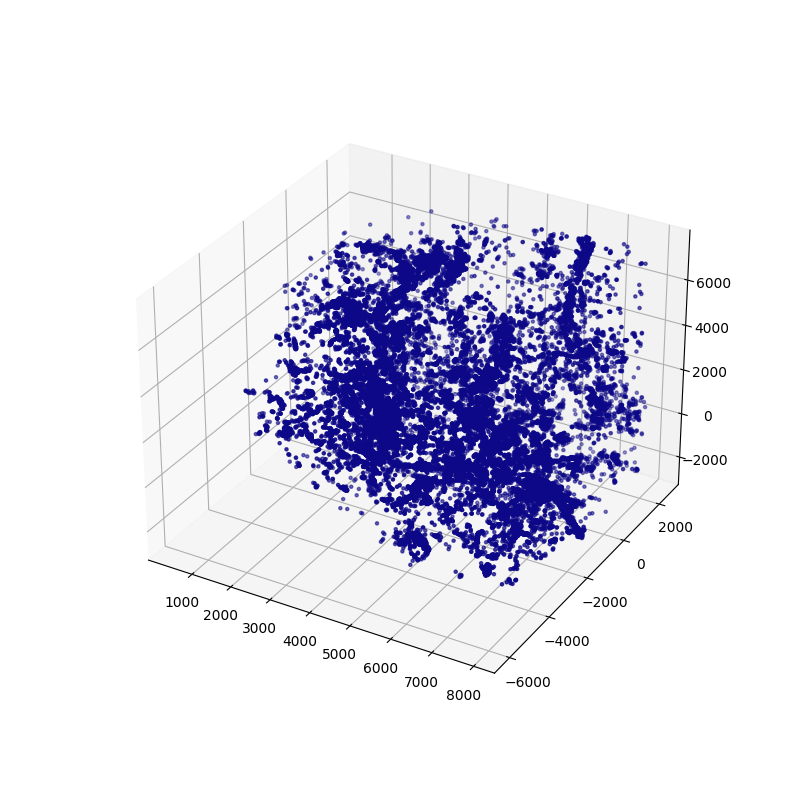

1.0186114998591018 -39.13553845479429 -38.42047577531539


<IPython.core.display.Javascript object>


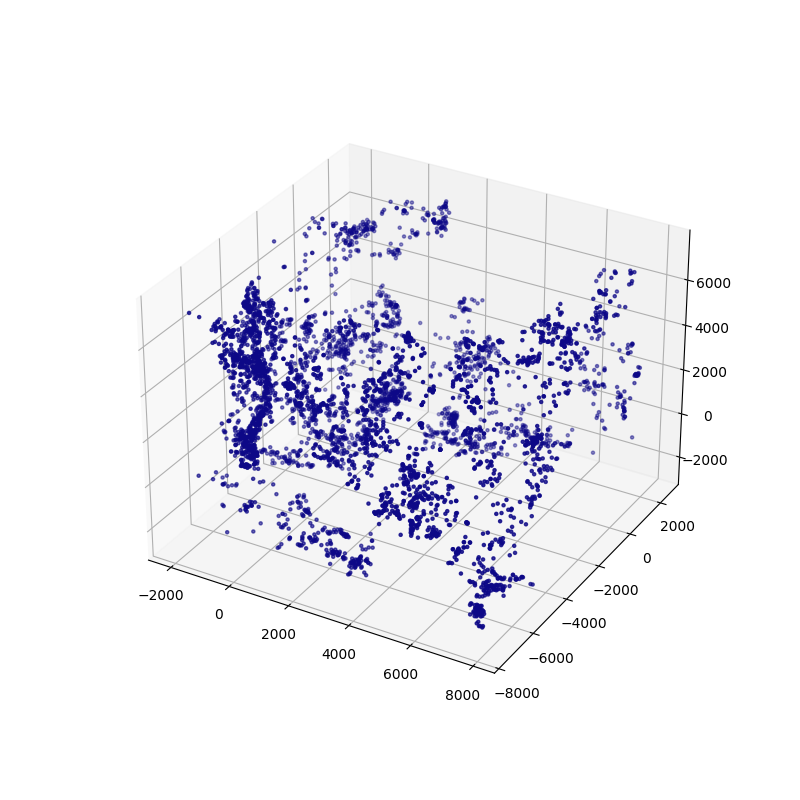

1.022936947150594 -28.221470532433838 -27.58867065173974


<IPython.core.display.Javascript object>


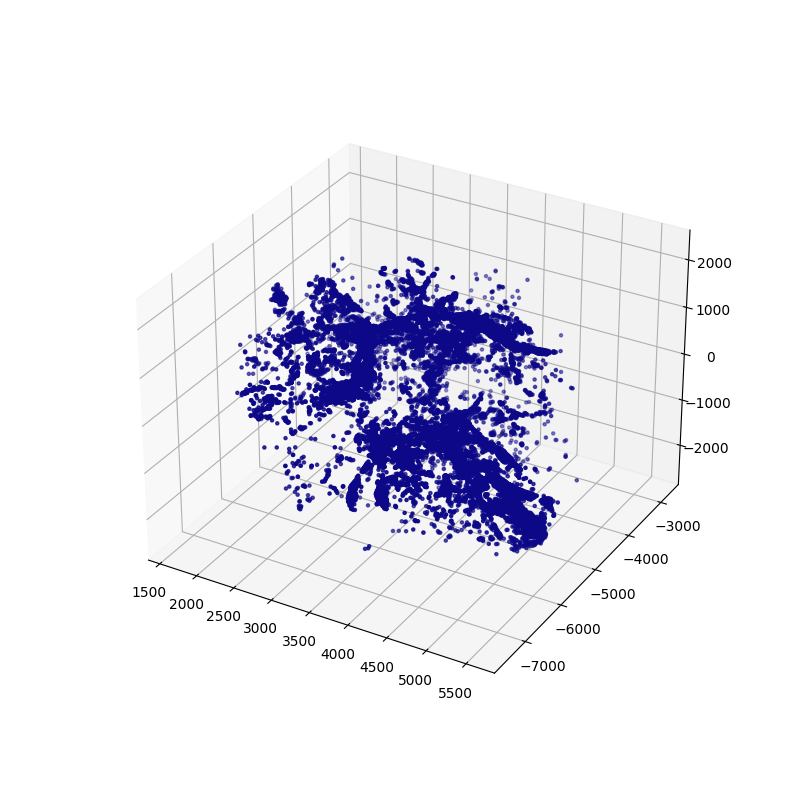

1.114086115995959 -20.549014369767086 -18.444727094904053


<IPython.core.display.Javascript object>


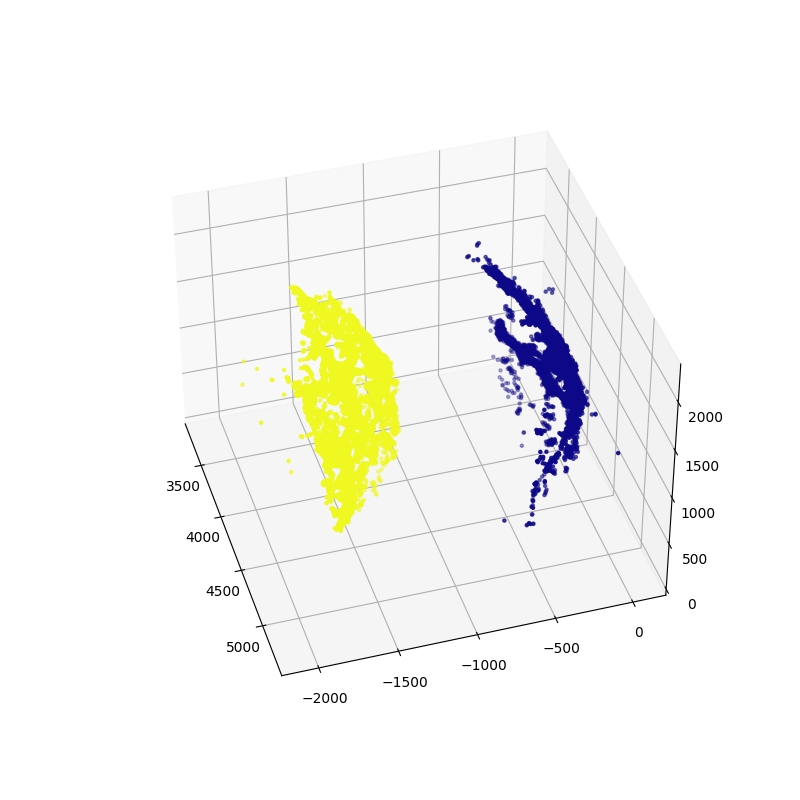

1.0137549169422677 -36.31911079753498 -35.82632270438923


<IPython.core.display.Javascript object>


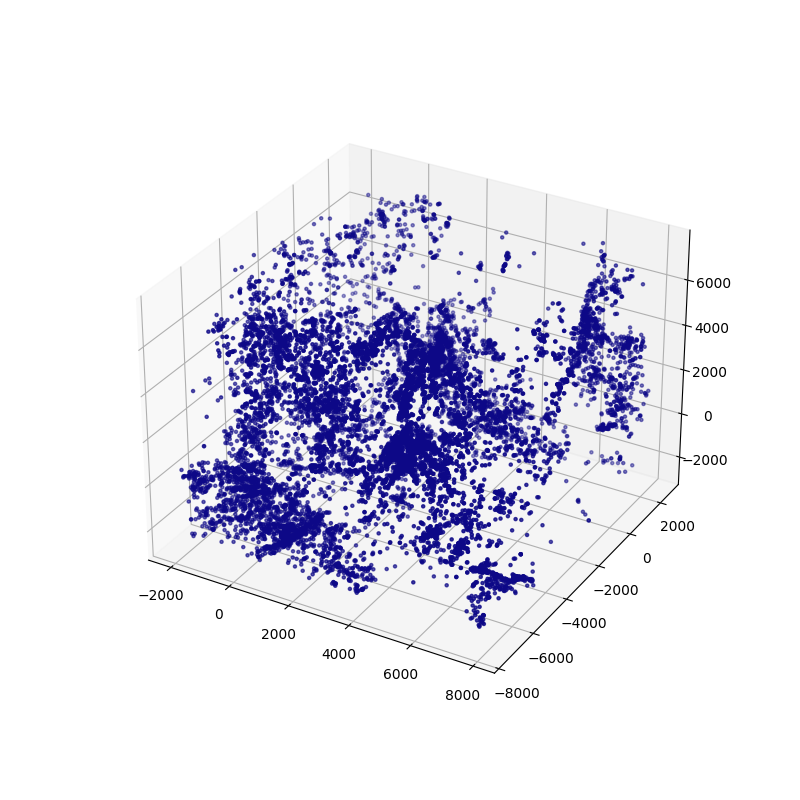

<ipython-input-26-ae1197604bc8>:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  clusters = np.array(clusters)
<ipython-input-26-ae1197604bc8>:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  labels = np.array(labels)


In [26]:
clusters = []
labels = []
elbo_rat = []

for val in values.copy():
    plot_dat = sub_data[pred_y1 == val]
    plot_y = pred_y1[pred_y1 == val]
    
    model = GaussianMixture(n_components=1)
    model.fit(plot_dat)
    m1 = model.lower_bound_
    
    model = GaussianMixture(n_components=2)
    model.fit(plot_dat)
    m2 = model.lower_bound_

    print(m1 / m2, m1, m2)
    elbo_rat.append(m1 / m2)
    
    if (m1 / m2) < 1.075:
        clusters.append(plot_dat)
        labels.append(plot_y)
        
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(projection='3d')
        ax.scatter(plot_dat.T[0], plot_dat.T[1], plot_dat.T[2], c=plot_y, marker=".", cmap="plasma")
        plt.show()

    else:
        
        plot_pred_y = model.predict(plot_dat)
        new_label = len(values)
        
        clusters.append(plot_dat[plot_pred_y==0])
        labels.append(plot_y[plot_pred_y==0])
        
        clusters.append(plot_dat[plot_pred_y==1])
        plot_y[plot_pred_y==1] = new_label
        labels.append(plot_y[plot_pred_y==1])
        values.append(new_label)
        
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(projection='3d')
        ax.scatter(plot_dat.T[0], plot_dat.T[1], plot_dat.T[2], c=plot_pred_y, marker=".", cmap="plasma")
        plt.show()

clusters = np.array(clusters)
labels = np.array(labels)

In [27]:
for ind, clust in enumerate(clusters):
    print(clust.shape, labels[ind].shape)
    
    if ind == 0:
        all_clusters = np.array(clust)
        all_labs = np.array(labels[ind])
    else:
        all_clusters = np.concatenate([all_clusters, clust])
        all_labs = np.concatenate([all_labs, labels[ind]])
    
#     fig = plt.figure(figsize=(8, 8))
#     ax = fig.add_subplot(projection='3d')
#     ax.scatter(clust.T[0], clust.T[1], clust.T[2], c=labels[ind], marker=".", cmap="plasma")
#     plt.show()



(35257, 7) (35257,)
(134098, 7) (134098,)
(55079, 7) (55079,)
(115046, 7) (115046,)
(67827, 7) (67827,)
(55769, 7) (55769,)
(92135, 7) (92135,)
(47071, 7) (47071,)
(4501, 7) (4501,)
(43767, 7) (43767,)
(7800, 7) (7800,)
(22771, 7) (22771,)
(13643, 7) (13643,)


<IPython.core.display.Javascript object>


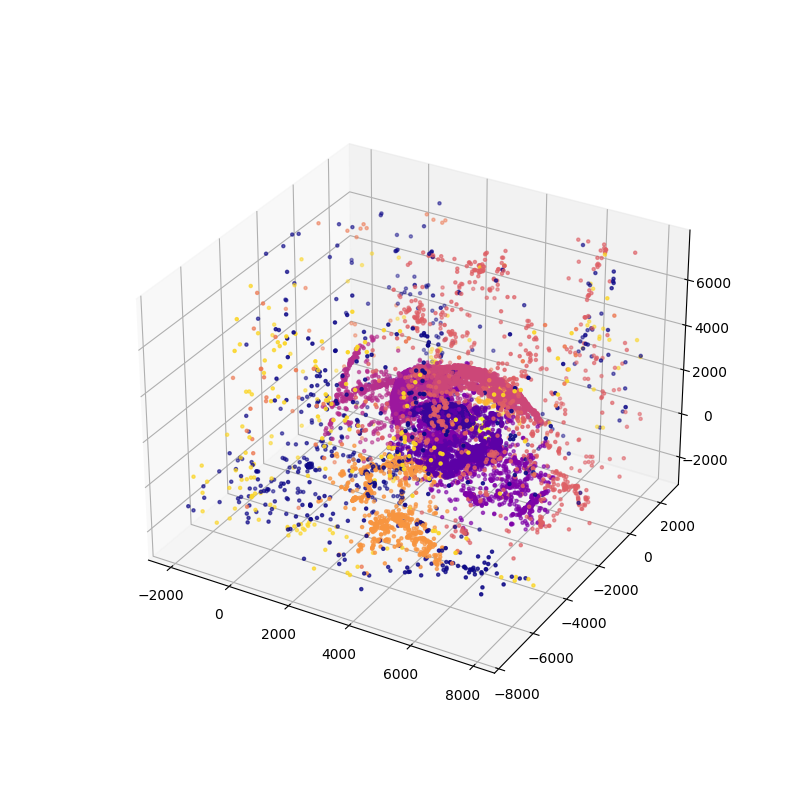

In [28]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

plot_data = all_clusters[::50]
plot_y = all_labs[::50]

ax.scatter(plot_data.T[0], plot_data.T[1], plot_data.T[2], c=plot_y, marker=".", cmap="plasma")

plt.show()

<IPython.core.display.Javascript object>


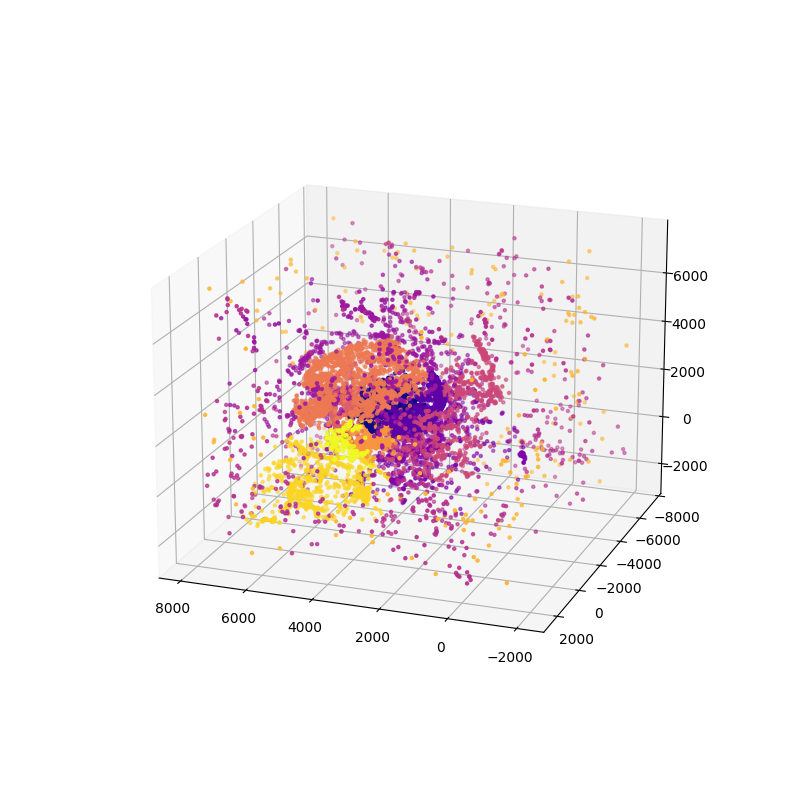

In [39]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

plot_data = all_clusters[::50]
plot_y = all_labs[::50]

ax.scatter(plot_data.T[0], plot_data.T[1], plot_data.T[2], c=plot_y, marker=".", cmap="plasma")

plt.show()

In [41]:
# all_clusters
# # all_labs
# print(all_clusters.shape, all_labs.shape)
# np.savetxt('all_clusters.txt', all_clusters)
# np.savetxt('all_labs.txt', all_labs)

(694764, 7) (694764,)


In [2]:
all_clusters = np.loadtxt('all_clusters.txt')
all_labs = np.loadtxt('all_labs.txt')
print(all_clusters.shape, all_labs.shape)

(694764, 7) (694764,)


In [3]:
# find each group average nn-distance

classes = np.unique(all_labs)
print(f"Classes {classes}")
mean_dist = []

for c in classes:

    clust = all_clusters[all_labs==c]
    dists = []
    # data was shuffled at the very beginning
    for i in range(400):
        point = clust[i]
        dist_to_all = np.sqrt(((clust[:,[0, 1, 2]] - point[[0, 1, 2]]) ** 2).sum(1))
        dist_to_all = np.sort(dist_to_all)
        dists.append(dist_to_all[1])

    dists = np.array(dists)
    mean_dist.append(dists.mean())
    
mean_dist = np.array(mean_dist)
print(mean_dist)

Classes [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
[ 4.55578612  2.95835096  6.37088597 16.49990429 19.99416659 44.50150815
 12.95649353  7.7975142   9.94670664  5.40811704 83.71878653  9.2221603
 11.82171398]


In [ ]:
# set all labels to -1 for point with different label in 2 * avg_nn-distance 
# (3 times? - no, every point touched got changed)

all_labs_cp = all_labs.copy()
point_steps=1

for i in range(0, all_clusters.shape[0], point_steps):
    if i%25000 == 0:
        print(f"Current: {i/all_clusters.shape[0]:0.3f} [{i} / {all_clusters.shape[0]}]")
#     if i > 10000:
#         break
    
    point = all_clusters[i]
    label = all_labs_cp[i]
    clusters = np.delete(all_clusters, i, axis=0)

    dist_to_all = ((clusters[:,[0, 1, 2]] - point[[0, 1, 2]]) ** 2).sum(1) 
    dist_to_all = dist_to_all - 2. * mean_dist[int(label)]
    
    prox_points = clusters[dist_to_all <= 0.]
    prox_labs = clusters[dist_to_all <= 0.]

    sum_diff_labs = (prox_labs != label).sum()
    sum_neg_labs = (prox_labs == -1.).sum()

    # only set -1 if actual different predicted value in nn
    if (sum_diff_labs - sum_neg_labs) >= 1.:
#         print(sum_diff_labs, sum_neg_labs)
#         print(i, (prox_labs != label).sum())
        all_labs_cp[i] = -1000.
    

classes, counts = np.unique(all_labs_cp, return_counts=True)
print(f"Classes {classes}, counts {counts}")
quota = counts[0] / (all_clusters.shape[0] / point_steps)
print(f"ratio labels cleaned per point studied {quota:0.2f}")

Current: 0.000 [0 / 694764]
Current: 0.036 [25000 / 694764]
Current: 0.072 [50000 / 694764]
Current: 0.108 [75000 / 694764]
Current: 0.144 [100000 / 694764]
Current: 0.180 [125000 / 694764]
Current: 0.216 [150000 / 694764]
Current: 0.252 [175000 / 694764]
Current: 0.288 [200000 / 694764]
Current: 0.324 [225000 / 694764]
Current: 0.360 [250000 / 694764]
Current: 0.396 [275000 / 694764]
Current: 0.432 [300000 / 694764]
Current: 0.468 [325000 / 694764]
Current: 0.504 [350000 / 694764]
Current: 0.540 [375000 / 694764]
Current: 0.576 [400000 / 694764]
Current: 0.612 [425000 / 694764]
Current: 0.648 [450000 / 694764]
Current: 0.684 [475000 / 694764]
Current: 0.720 [500000 / 694764]
Current: 0.756 [525000 / 694764]
Current: 0.792 [550000 / 694764]
Current: 0.828 [575000 / 694764]


In [128]:
all_labs_cp[all_labs_cp==-1000.] = -1.

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

plot_data = all_clusters_cp[::point_steps]
plot_y = all_labs_cp[::point_steps]

ax.scatter(plot_data.T[0], plot_data.T[1], plot_data.T[2], c=plot_y, marker=".", cmap="plasma")

plt.show()

In [ ]:
# np.savetxt('all_labs_cleaned_all.txt', all_labs_cp)

In [5]:
all_labs_cp  = np.loadtxt('all_labs_cleaned.txt')

<IPython.core.display.Javascript object>


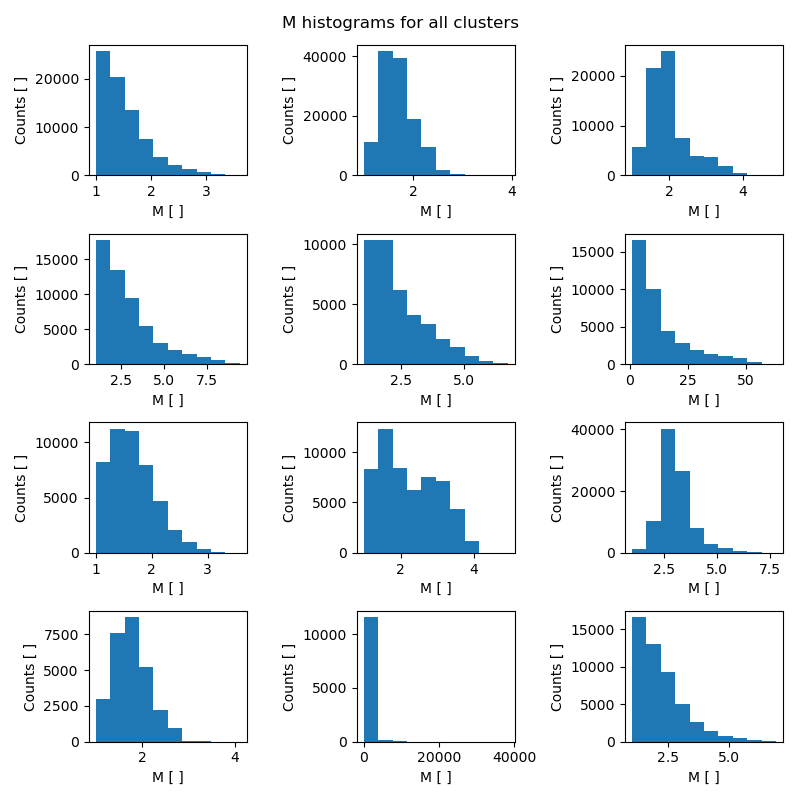

In [27]:
fig, axs = plt.subplots(4, 3, figsize=(8, 8))
fig.suptitle("M histograms for all clusters")
for c_label in range(int(all_labs_cp.max())):
    data = all_clusters[all_labs_cp==c_label]
    axs.flat[c_label].hist(data.T[-1])
    axs.flat[c_label].set(xlabel="M [ ]", ylabel="Counts [ ]")
plt.tight_layout()
plt.show()